# I. Part 1

## 1. Getting a dataset

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

13:00:59: Debug: Adding duplicate image handler for 'Windows bitmap file'
13:00:59: Debug: Adding duplicate animation handler for '1' type
13:00:59: Debug: Adding duplicate animation handler for '2' type
13:01:00: Debug: Adding duplicate image handler for 'Windows bitmap file'
13:01:00: Debug: Adding duplicate animation handler for '1' type
13:01:00: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:956): Gtk-CRITICAL **: 13:01:00.241: gtk_window_resize: assertion 'height > 0' failed


In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [4]:
# Variables
dataset_id = 'ds000171'
bids_root = '/home/jovyan/Data/dataset/ds000171'
subject = 'control01'  
subject_dir = 'sub-{}'.format(subject)

# Check if the dataset directory exists
if op.exists(bids_root):
    print(f"Removing existing dataset at {bids_root}")
    subprocess.run(["rm", "-rf", bids_root], check=True)

# Download the dataset again
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id,
                "--target-dir", bids_root,
                "--include", op.join(subject_dir, '*'),
               ], check=True)

###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-{}'.format(subject)))
mkdir_no_exist(op.join(preproc_root, 'sub-{}'.format(subject), 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-{}'.format(subject), 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-{}'.format(subject), 'fmap'))


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:48,  8.95 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   0%|          | 0.00/8.77M [00:00<?, ?B/s]
sub-control01_task-music_run-1_events.tsv: 0.00B [00:00, ?B/s]
sub-control01_T1w.nii.gz:   3%|▎         | 287k/8.77M [00:00<00:07, 1.17MB/s]
sub-control01_T1w.nii.gz:   7%|▋         | 609k/8.77M [00:00<00:05, 1.53MB/s]0<?, ?B/s]

sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]

                                                                                    

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]


sub-control01_T1w.nii.gz:  17%|█▋        | 1.46M/8.77M [00:00<00:02, 3.76MB/s]<?, ?B/s]
sub-control01_T1w.nii.gz:  34%|███▍      | 3.00M/8.77M [00:00<00:00, 7.46MB/s]0<01:36, 366kB/s]

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 83.5k/33.8M [00:00<01:15, 469kB/s]


sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 83.6k/33.9M [00:00<01:15, 471kB/s]
sub-control01_T1w.nii.gz:  48%|████▊     | 4.19M/8.77M [00:

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


In [5]:
print_dir_tree(bids_root, max_depth=4)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


# Lab 2

## 2. Anatomical preprocessing

In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:956): Gdk-WARNING **: 13:02:32.935: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [7]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01")

Done with BET.


In [8]:
fsleyesDisplay.load(resulting_mask_path)

In [9]:
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

Done with BET.


In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

In [11]:
##################################
# Fill me with the code to use your mask
# To help you, we provide you with the skeleton of two potential approaches.
# You can fill either of them. Do not forget to test them by visualizing the result!
# For fslmaths, you can either read the documentation, or execute it without argument by running os.system('fslmaths')
##################################

# Option 1: Pythonic approach.
def apply_python_mask_approach(img_path, mask_path, masked_img_path):
    """
    The first approach, Pythonic way. The goal is, given a mask, to apply it to a T1 where the brain is to be extracted.
    
    YOU SHOULD COMPLETE THE METHOD AS IT DOES NOT WORK RIGHT NOW!

    Parameters
    ----------
    img_path: str
        Path to the image on which we would like to apply the mask (in your case, the T1 with the skull still on). Should be a .nii.gz file
    mask_path: str
        Path to the mask you would like to apply to your image. Should be a .nii.gz file, containing only binary values (0 or 1)
    masked_img_path: str
        Path to which the resulting image will be saved.
    """
    import nibabel as nib

    # Load both the T1 and the mask from disk
    img = nib.load(img_path)
    mask = nib.load(mask_path)
    
    # Load the data from both above images as numpy arrays
    img_data = img.get_fdata()
    mask_data = mask.get_fdata()

    #######################
    # Solution 1
    # Create an empty image and select all which falls in the mask (perhaps the most natural way to think about the mask)
    #######################
    # In all positions within the mask, get the image content
    saved_img_data = np.zeros(img_data.shape)
    saved_img_data[mask_data > 0] = img_data[mask_data > 0]

    # Save the image to disk, by creating a new Nifti image and then writing it out
    img_out = nib.Nifti1Image(saved_img_data,img.affine, img.header)
    nib.save(img_out, masked_img_path)

    #######################
    # Solution 2
    # Another approach is to remove from img_data all that is outside the mask.
    #######################
    
    # In all positions OUTSIDE the mask (where it is equal to 0), throw away the image
    img_data[mask_data == 0] = 0
    
    # Save the image to disk, by creating a new Nifti image and then writing it out
    img_out = nib.Nifti1Image(img_data,img.affine, img.header)
    nib.save(img_out, masked_img_path)
    
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    ###########################
    # Solution
    # By reading fslmaths documentation, one can see that the -mas option is exactly what we desire.
    ###########################
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

########################
# CHOOSE ONE OF THE TWO TO IMPLEMENT IT AND LAUNCH IT
########################
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)
apply_python_mask_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

In [13]:
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

#########################
# Solution
# By reading above: we must apply FAST to the brain-extracted image. Thus we must use the BET path brain.
##########################
fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [14]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-cont

In [15]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## 3. Coregistration of images

In [16]:
import threading

def launch_freeview(img_list):
    """
    Wrapper around freeview to launch it with several images.
    This wrapper is necessary to launch freeview in a separate thread, ensuring the notebook is free to do something else.

    Parameters
    ----------
    img_list: list of string
        List of images (files) to load. Assumed by default to be volume files.
    """
    args = []
    
    for i in range(len(img_list)):
        args.append("-v")
        args.append(img_list[i])
    # Run the command
    subprocess.run(["freeview"] + args)

imgList = [op.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz'), 
           op.join(preproc_root, "sub-control01", "anat", "sub-control01_T1w.nii.gz:colormap=greyscale")] # Modify here this list to add any image you want, in .nii.gz format
freeview_thread = threading.Thread(target=launch_freeview, args=(imgList,)) # Remark the (imgList,) when passing to args. This is very important to make Thread work properly

# Start the thread
freeview_thread.start()

print("Freeview is running in a separate thread.")

Freeview is running in a separate thread.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-jovyan'


In [17]:
from fsl.wrappers import flirt

# The two images
subject_id = 'control01'
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

###################
# Select which image should be target or reference
# ANSWER:
# The subject anatomical will most often be the target, as the template is usually where we want to map our subjects for 
# group comparison.
# There are cases, however, where we may want the subject anatomical to be the reference. This is the case when we want to map an 
# atlas to a subject while preserving the subject as much as possible.
# We showcase here the case where the subject is chosen as target.
##################
target = subject_anatomical
reference = mni_template
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)


Final result: 
0.003341 0.005724 -1.116060 204.820462 
-0.933200 0.500882 0.006703 178.661677 
0.501569 1.049029 -0.003770 -149.723790 
0.000000 0.000000 0.000000 1.000000 



{}

In [18]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)

In [19]:
#######
# Solution
# We consider only within-modalities costs, as the two images belong to the same modality: least squares and normalized correlation ratio.
# Remark correlation ratio also technically works
#######
possible_costs = ['mutualinfo', 'corratio', 'normcorr', 'normmi', 'leastsq', 'labeldiff']
costs_to_consider = [ 'leastsq', 'normcorr' ]

for c in costs_to_consider:
    flirt(target, reference, out=result + '_' + c, cost=c)


Final result: 
3.458371 1.648305 3.627273 -990.534765 
-2.861950 1.235282 4.578044 -54.943603 
0.433791 -5.372595 2.300280 588.875671 
0.000000 0.000000 0.000000 1.000000 


Final result: 
0.003107 0.005315 -1.116440 204.932830 
-0.935071 0.500262 0.007008 178.944986 
0.501467 1.049276 -0.004127 -149.788866 
0.000000 0.000000 0.000000 1.000000 



In [20]:
for c in costs_to_consider:
    fsleyesDisplay.load(result + '_' + c)

In [21]:
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')

# Compute the transformation (non linear) to put align the moving image to the fixed image
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN' )

# After the transformation has been computed, apply it
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])

# Save the image to disk
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))
ants.image_write(warpedImage, resultAnts)

# Inspect the results with FSLeyes or freeview, as you prefer :)

In [22]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(result)
fsleyesDisplay.load(resultAnts)

In [23]:
os.system('fsl_anat')

Usage: fsl_anat [options] -i <structural image>
       fsl_anat [options] -d <existing anat directory>
 
Arguments (You may specify one or more of):
  -i <strucural image>         filename of input image (for one image only)
  -d <anat dir>                directory name for existing .anat directory where this script will be run in place
  -o <output directory>        basename of directory for output (default is input image basename followed by .anat)
  --clobber                    if .anat directory exist (as specified by -o or default from -i) then delete it and make a new one
  --strongbias                 used for images with very strong bias fields
  --weakbias                   used for images with smoother, more typical, bias fields (default setting)
  --noreorient                 turn off step that does reorientation 2 standard (fslreorient2std)
  --nocrop                     turn off step that does automated cropping (robustfov)
  --nobias                     turn off steps tha

0

In [24]:
import shutil

def fsl_anat_wrapped(anatomical_target, output_path):
    os.system('fsl_anat -i {} --clobber --nosubcortseg -o {}'.format(anatomical_target,output_path))
    # Now move all files from the output_path.anat folder created by FSL to 
    # the actual output_path
    fsl_anat_path = output_path+'.anat'
    files_to_move = glob.glob(op.join(fsl_anat_path, '*'))
    for f in files_to_move:
        shutil.move(f, op.join(output_path, op.split(f)[1]))
    
    # Remove the output_path.anat folder
    os.rmdir(fsl_anat_path)

In [25]:
fsl_anat_wrapped(anatomical_path, op.join(preproc_root, 'sub-control01', 'anat'))

Thu Oct 24 13:12:55 UTC 2024
Reorienting to standard orientation
Thu Oct 24 13:13:01 UTC 2024
Automatically cropping the image
Starting Single Image Segmentation
T1-weighted image
Imagesize : 176 x 256 x 170
Pixelsize : 1.2 x 1 x 1

1 5.15907
2 5.58726
3 5.94017
KMeans Iteration 0
KMeans Iteration 1
KMeans Iteration 2
KMeans Iteration 3
KMeans Iteration 4
KMeans Iteration 5
KMeans Iteration 6
KMeans Iteration 7
KMeans Iteration 8
KMeans Iteration 9
KMeans Iteration 10
KMeans Iteration 11
KMeans Iteration 12
KMeans Iteration 13
KMeans Iteration 14
Tanaka Iteration 0 bias field 10
Tanaka-inner-loop-iteration=0 MRFWeightsTotal=2.0141e+07 beta=0.02
Tanaka-inner-loop-iteration=1 MRFWeightsTotal=2.04326e+07 beta=0.02
Tanaka-inner-loop-iteration=2 MRFWeightsTotal=2.04422e+07 beta=0.02
Tanaka-inner-loop-iteration=3 MRFWeightsTotal=2.04426e+07 beta=0.02
Tanaka-inner-loop-iteration=4 MRFWeightsTotal=2.04426e+07 beta=0.02
 CLASS 1 MEAN 100.155 STDDEV 131.718 CLASS 2 MEAN 257.478 STDDEV 69.432 CLA

In [26]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- MNI152_T1_2mm_brain_mask_dil1.nii.gz
|--------------- MNI_to_T1_nonlin_field.nii.gz
|--------------- T1.nii.gz
|--------------- T12std_skullcon.mat
|--------------- T1_biascorr.nii.gz
|--------------- T1_biascorr_bet_skull.nii.gz
|--------------- T1_biascorr_brain.nii.gz
|--------------- T1_biascorr_brain_mask.nii.gz
|--------------- T1_fast_bias.nii.gz
|--------------- T1_fast_mixeltype.nii.gz
|--------------- T1_fast_pve_0.nii.gz
|--------------- T1_fast_pve_1.nii.gz
|--------------- T1_fast_pve_2.nii.gz
|--------------- T1_fast_pveseg.nii.gz
|--------------- T1_fast_restore.nii.gz
|--------------- T1_fast_seg.nii.gz
|--------------- T1_fullfov.nii.gz
|--------------- T1_nonroi2roi.mat
|--------------- T1_orig.nii.gz
|--------------- T1_orig2roi.mat
|--------------- T1_orig2std.mat
|--------

In [27]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm')))
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'anat', 'T1_to_MNI_lin'))
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'anat', 'T1_to_MNI_nonlin'))

# Lab 3

## 4. fMRI preprocessing

In [29]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root_demo, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz'))

Text(0, 0.5, 'Mean voxel intensity')

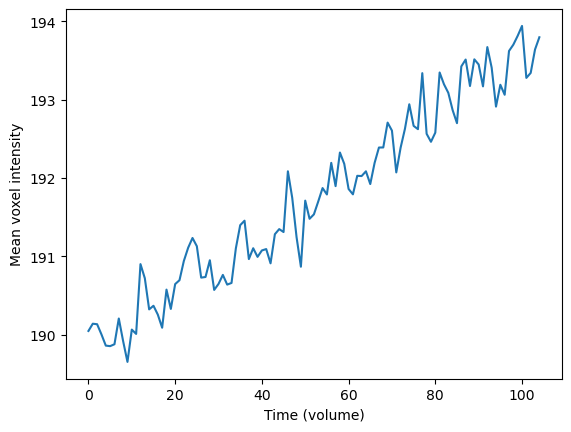

In [31]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root_demo, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [34]:
from fsl.wrappers import mcflirt

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [35]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- MNI152_T1_2mm_brain_mask_dil1.nii.gz
|--------------- MNI_to_T1_nonlin_field.nii.gz
|--------------- T1.nii.gz
|--------------- T12std_skullcon.mat
|--------------- T1_biascorr.nii.gz
|--------------- T1_biascorr_bet_skull.nii.gz
|--------------- T1_biascorr_brain.nii.gz
|--------------- T1_biascorr_brain_mask.nii.gz
|--------------- T1_fast_bias.nii.gz
|--------------- T1_fast_mixeltype.nii.gz
|--------------- T1_fast_pve_0.nii.gz
|--------------- T1_fast_pve_1.nii.gz
|--------------- T1_fast_pve_2.nii.gz
|--------------- T1_fast_pveseg.nii.gz
|--------------- T1_fast_restore.nii.gz
|--------------- T1_fast_seg.nii.gz
|--------------- T1_fullfov.nii.gz
|--------------- T1_nonroi2roi.mat
|--------------- T1_orig.nii.gz
|--------------- T1_orig2roi.mat
|--------------- T1_orig2std.mat
|--------

In [36]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [37]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000843,0.000589,-0.000283,-0.020640,-0.088168,-0.061575
1,0.000587,0.000481,-0.000326,-0.020651,-0.071060,-0.046486
2,0.000933,0.000589,-0.000394,-0.020618,-0.046722,-0.035206
3,0.000550,0.000816,-0.000394,-0.020571,-0.072742,-0.049830
4,0.000858,0.000589,-0.000394,-0.020618,-0.060591,-0.083145
...,...,...,...,...,...,...
100,0.000952,-0.000853,0.000040,-0.013383,0.118385,0.187859
101,0.000457,-0.001224,0.000051,-0.009799,0.133098,0.214907
102,0.001244,-0.001305,0.000298,-0.028813,0.134919,0.187284
103,0.000731,-0.001537,0.000073,-0.030532,0.127386,0.185354


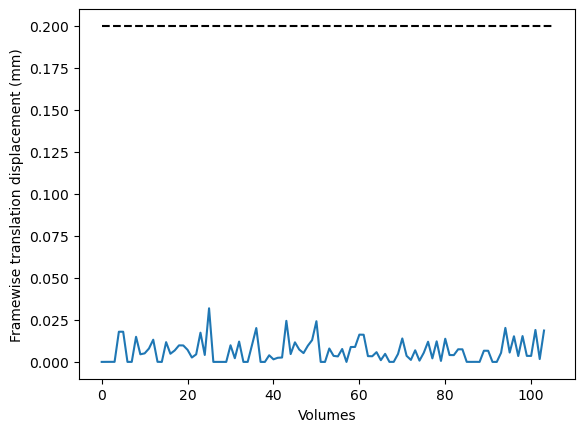

In [39]:
# write your code here to inspect quickly the translation on X :)
#%matplotlib inline

# Getting the translation is easy
trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 105,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

In [40]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [41]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

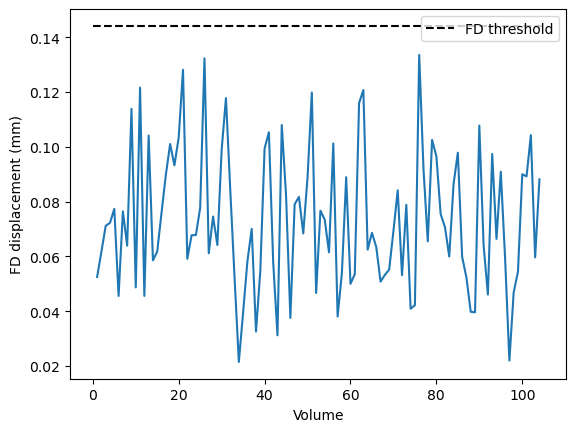

In [43]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 105, colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [44]:
np.where(fd > threshold)[0] + 1

array([], dtype=int64)

In [45]:
subprocess.run(['epi_reg'])


Usage: epi_reg [options] --epi=<EPI image> --t1=<wholehead T1 image> --t1brain=<brain extracted T1 image> --out=<output name>
 
Optional arguments
  --fmap=<image>         : fieldmap image (in rad/s)
  --fmapmag=<image>      : fieldmap magnitude image - wholehead extracted
  --fmapmagbrain=<image> : fieldmap magnitude image - brain extracted
  --gdc=<image>          : Gradient-distortion corection warpfield
  --wmseg=<image>        : white matter segmentation of T1 image
  --echospacing=<val>    : Effective EPI echo spacing (sometimes called dwell time) - in seconds
  --pedir=<dir>          : phase encoding direction, dir = x/y/z/-x/-y/-z
  --weight=<image>       : weighting image (in T1 space)
  --nofmapreg            : do not perform registration of fmap to T1 (use if fmap already registered) 
  --noclean              : do not clean up intermediate files
  -v                     : verbose output
  -h                     : display this help message
 
e.g.:  epi_reg --epi=example_func

CompletedProcess(args=['epi_reg'], returncode=1)

In [48]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- MNI152_T1_2mm_brain_mask_dil1.nii.gz
|--------------- MNI_to_T1_nonlin_field.nii.gz
|--------------- T1.nii.gz
|--------------- T12std_skullcon.mat
|--------------- T1_biascorr.nii.gz
|--------------- T1_biascorr_bet_skull.nii.gz
|--------------- T1_biascorr_brain.nii.gz
|--------------- T1_biascorr_brain_mask.nii.gz
|--------------- T1_fast_bias.nii.gz
|--------------- T1_fast_mixeltype.nii.gz
|--------------- T1_fast_pve_0.nii.gz
|--------------- T1_fast_pve_1.nii.gz
|--------------- T1_fast_pve_2.nii.gz
|--------------- T1_fast_pveseg.nii.gz
|--------------- T1_fast_restore.nii.gz
|--------------- T1_fast_seg.nii.gz
|--------------- T1_fullfov.nii.gz
|--------------- T1_nonroi2roi.mat
|--------------- T1_orig.nii.gz
|--------------- T1_orig2roi.mat
|--------------- T1_orig2std.mat
|--------

In [49]:
from fsl.wrappers import epi_reg

#################
# Solution
# We use the motion corrected EPI 
##################
# We use the motion corrected EPI
epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco_vol_middle')

use_single_vol = True

if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    fslroi(epi_target, ref_vol_name, str(52), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])

Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.311916 0.999201 -0.039747 -0.004216 0.000000 0.039793 0.999142 0.011458 0.000000 0.003757 -0.011617 0.999925 0.000000 -5.459976 9.761198 -1.063915 1.000000 


In [50]:
###############
# Solution
# White matter corresponds to pve_2.
##############

white_matter_segmentation = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast_pve_2.nii.gz') # We provide the white matter segmentation

subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.298373 0.999223 -0.039116 -0.004812 0.000000 0.039166 0.999174 0.010820 0.000000 0.004384 -0.011000 0.999930 0.000000 -5.397363 9.584313 -0.845888 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle', '--t1=/home/jovyan/Data/dataset/ds000171/sub-control01/anat/sub-control01_T1w', '--t1brain=/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w', '--out=/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_bbr', '--wmseg=/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2.nii.gz'], returncode=0)

In [51]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)

In [52]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

In [53]:
cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

In [54]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- MNI152_T1_2mm_brain_mask_dil1.nii.gz
|--------------- MNI_to_T1_nonlin_field.nii.gz
|--------------- T1.nii.gz
|--------------- T12std_skullcon.mat
|--------------- T1_biascorr.nii.gz
|--------------- T1_biascorr_bet_skull.nii.gz
|--------------- T1_biascorr_brain.nii.gz
|--------------- T1_biascorr_brain_mask.nii.gz
|--------------- T1_fast_bias.nii.gz
|--------------- T1_fast_mixeltype.nii.gz
|--------------- T1_fast_pve_0.nii.gz
|--------------- T1_fast_pve_1.nii.gz
|--------------- T1_fast_pve_2.nii.gz
|--------------- T1_fast_pveseg.nii.gz
|--------------- T1_fast_restore.nii.gz
|--------------- T1_fast_seg.nii.gz
|--------------- T1_fullfov.nii.gz
|--------------- T1_nonroi2roi.mat
|--------------- T1_orig.nii.gz
|--------------- T1_orig2roi.mat
|--------------- T1_orig2std.mat
|--------

In [55]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_bbr', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_bbr_smoothed-6mm'], returncode=0)

In [56]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')

## 5. Diffusion data and tractography generation

In [57]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
hardi_root_path = op.split(hardi_fname)[0]
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

In [58]:
print('data.shape: ',data.shape)
print('affine.shape: ',affine.shape)
print('hardi_img.shape: ',hardi_img.shape)

print('labels.shape: ',labels.shape)
print('bvals.shape: ',bvals.shape)
print('bvecs.shape: ',bvecs.shape)

data.shape:  (81, 106, 76, 160)
affine.shape:  (4, 4)
hardi_img.shape:  (81, 106, 76, 160)
labels.shape:  (81, 106, 76)
bvals.shape:  (160,)
bvecs.shape:  (160, 3)


In [59]:
import os.path as op
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

print_dir_tree(hardi_root_path, max_depth=5)

|stanford_hardi/
|--- HARDI150.bval
|--- HARDI150.bvec
|--- HARDI150.nii.gz
|--- aparc-reduced.nii.gz
|--- label_info.txt


In [60]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(label_fname)
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[0]).cmap = 'brain_colours_spectrum'

In [61]:
white_matter_value = 1 # Fill with the value you read in FSLeyes for white matter!

In [62]:
##################
# Solution
# We show the fslmaths approach. Simply set upper and lower threshold to the white matter value in the parcellation.
##################
output_name = op.join(hardi_root_path,'extracted_wm')
subprocess.run(['fslmaths', label_fname, '-thr', str(white_matter_value), '-uthr', str(white_matter_value), '-bin', output_name])
fsleyesDisplay.load(output_name)

In [63]:
##################
# Solution
# We show the fslmaths approach.
##################

lower_threshold = 1 # Select the lower bound to include both white matter and corpus callosum slice
upper_threshold = 2 # Select the upper bound to include both white matter and corpus callosum slice
output_name = op.join(hardi_root_path,'extracted_wm_complete')

subprocess.run(['fslmaths', label_fname, '-thr', str(lower_threshold), '-uthr', str(upper_threshold), '-bin', output_name])
fsleyesDisplay.load(output_name)

In [64]:
#######
# Solution
# Remark we create an OR mask between the corpus callosum and white matter values.
# The total mask is simply set from this parcellation.
#######
corpus_callosum_slice_value = 2 # Fill with your value!
white_matter_value = 1 # Fill with your value !

total_white_matter = (labels == corpus_callosum_slice_value) | (labels == white_matter_value)

In [65]:
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

# Single fiber response function: the measured signal of a single fiber
# sume: regions where there are single coherent fiber populations
# auto_response_ssst: calculate FA for a ROI of radii equal to roi_radii in the center of the volume
# and return the response function estimated in that region for the voxels with FA higher than 0.7
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

# Instantiate the Constant Solid Angle model
csa_model = CsaOdfModel(gtab, sh_order_max=6)

In [66]:
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=total_white_matter, npeaks=5)

In [67]:
csa_peaks.peak_values.shape

(81, 106, 76, 5)

In [68]:
from fury import actor, window, ui
from ipyvtklink.viewer import ViewInteractiveWidget

In [69]:
scene = window.Scene()
slice_actor = actor.peak_slicer(csa_peaks.peak_dirs,
                            peaks_values=csa_peaks.peak_values,
                            affine=affine,mask=total_white_matter,)
scene.add(slice_actor)

showm = window.ShowManager(scene, size=(900,900), reset_camera=False)
showm.initialize()
ViewInteractiveWidget(scene.GetRenderWindow())

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: UserWarning: We'll no longer accept the way you call the __init__ function in future versions of FURY.

Here's how to call the Function __init__: __init__(self_value, scene='value', title='value', size='value', png_magnify='value', reset_camera='value', order_transparent='value', interactor_style='value', stereo='value', multi_samples='value', max_peels='value', occlusion_ratio='value')

  exec(code_obj, self.user_global_ns, self.user_ns)


ViewInteractiveWidget(height=836, layout=Layout(height='auto', width='100%'), width=900)

In [70]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

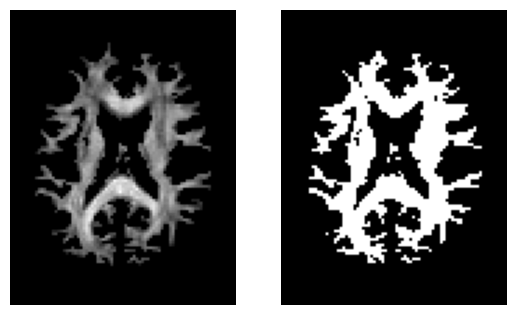

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

In [72]:
from dipy.tracking import utils

seed_mask = labels == 2 # Your code here to extract only the place of interest! 
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

In [73]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines_t = Streamlines(streamlines_generator)

In [74]:
streamlines_t

ArraySequence([array([[ -4.5, -44.5,   7.5]]), array([[ -4.5, -44.5,   7.5]]), array([[ -4.5, -44.5,   7.5]]), ..., array([[-0.5, 32.5, 12.5]]), array([[ 0.5, 32.5, 12.5]]), array([[ 0.5, 32.5, 12.5]])])

In [75]:
from dipy.viz import colormap

# Prepare the display objects.
color = colormap.line_colors(streamlines_t)

streamlines_actor = actor.line(streamlines_t,
                               colors=colormap.line_colors(streamlines_t))

# Create the 3D display.
scene = window.Scene()
scene.add(streamlines_actor)

showm = window.ShowManager(scene, size=(900,900), reset_camera=False)
showm.initialize()
ViewInteractiveWidget(scene.GetRenderWindow())

# Save still images for this static example. Or for interactivity use
#window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
#if interactive:
#    window.show(scene)

ViewInteractiveWidget(height=836, layout=Layout(height='auto', width='100%'), width=900)

In [76]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram, save_trk

# This is for the cc slice tractogram
sft = StatefulTractogram(streamlines_t, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_EuDX.trk", streamlines_t)
